In [1]:
#|default_exp init

## Initialization

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
DeviceCB?

In [5]:
# Set to avoid mps on mac - comment out
if def_device == 'mps': def_device = 'cpu'

In [6]:
def_device

'cpu'

In [7]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [8]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

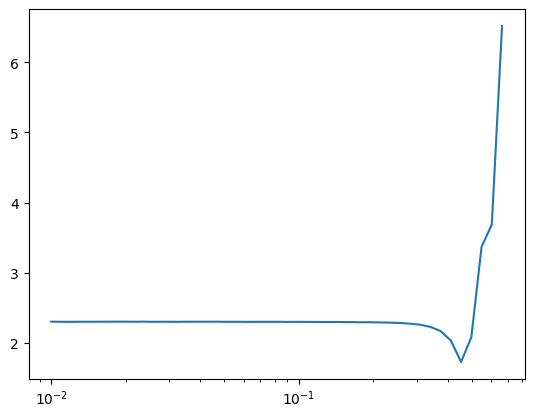

In [9]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1.e-2)

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStatsCB(append_stats, fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs, opt=optim.ActivationStatsCB)

accuracy,loss,epoch,train
0.163,2.302,0,True
0.482,1.551,0,False


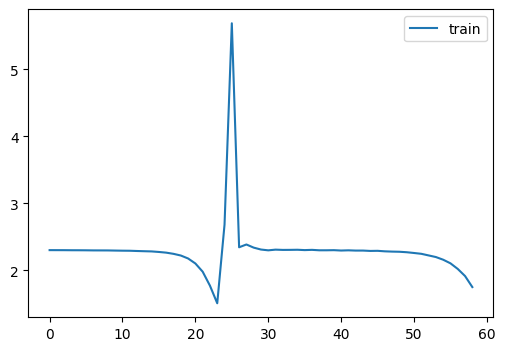

In [11]:
learn.fit(1)

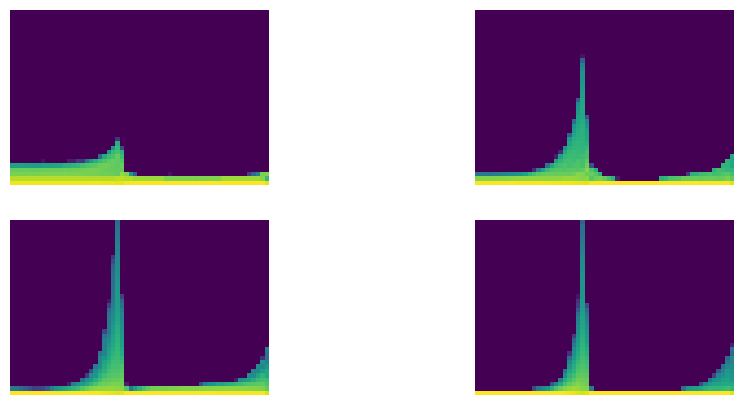

In [12]:
astats.color_dim()

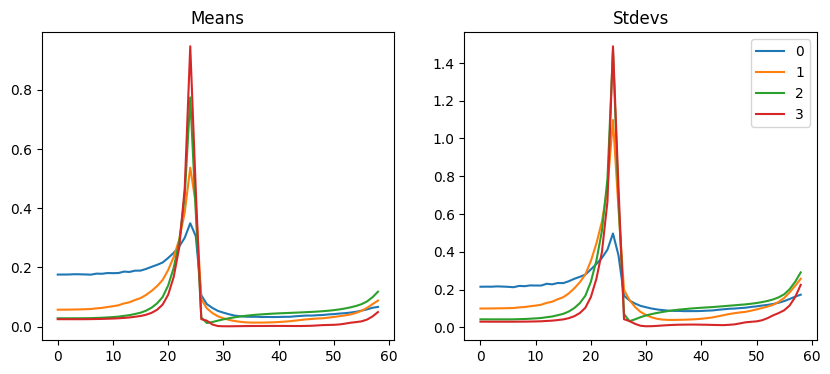

In [13]:
astats.plot_stats()

## Utility Functions to manage cleanup of memory etc

In [14]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [15]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [16]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

In [17]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

What this shows is that cumulative multiplication but random weights will result in numerical overflow very quickly.  If the weights are smaller then then causes them to very quickly all become zeros

In [18]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.


In [19]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 1.0 / math.sqrt(100))
x[0:5,0:5]

tensor([[-0.81, -0.20, -0.18,  0.24, -0.47],
        [ 0.04, -0.51,  0.52,  0.15,  0.53],
        [ 0.10, -0.10, -0.35, -0.23, -0.68],
        [ 0.03,  0.11, -1.07,  0.63,  0.05],
        [-1.11, -0.25,  0.61, -0.83, -0.14]])

This has worked in as much as the numbers are still within a sensible range

## Background

### Variance and Standard Deviation 

In [20]:
t = torch.tensor([1.,2.,4.,18])

In [21]:
m=t.mean();m

tensor(6.25)

In [22]:
(t-m).mean()

tensor(0.)

In [23]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [24]:
(t-m).abs().mean()

tensor(5.88)

The difference in the above is due to the larger effect of the outlier when we use a square term.  The mean absolute deviation is less affected by outliers and should probably be used more than it is.

There are two equivalent ways to calculate variance

In [25]:
(t-m).pow(2).mean(), (t*t).mean() - m*m

(tensor(47.19), tensor(47.19))

The latter is usually a lot easier to work with 

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Covariance is defined as:

$$\operatorname{cov}\left(X, Y\right) = \operatorname{E}\big[(\left(X - \operatorname{E}[X])(Y - \operatorname{E}[Y]) \big) \right] $$

Applying this in code we get

In [26]:
t

tensor([ 1.,  2.,  4., 18.])

In [27]:
u = t * 2
u *= torch.rand_like(t)/10 + 0.95
u

tensor([ 2.08,  3.93,  7.86, 35.53])

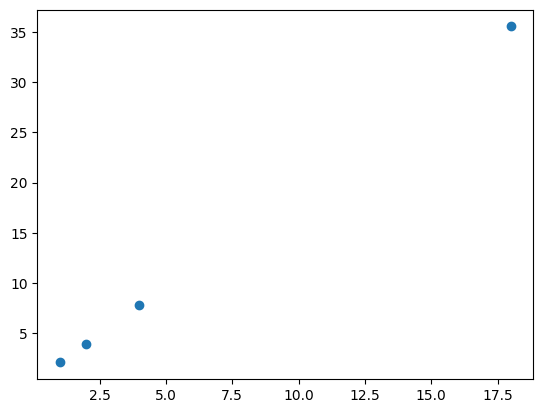

In [28]:
plt.scatter(t, u);

In [29]:
prod = (t-t.mean())*(u-u.mean())
prod

tensor([ 53.90,  35.80,  10.11, 272.41])

In [30]:
prod.mean()

tensor(93.05)

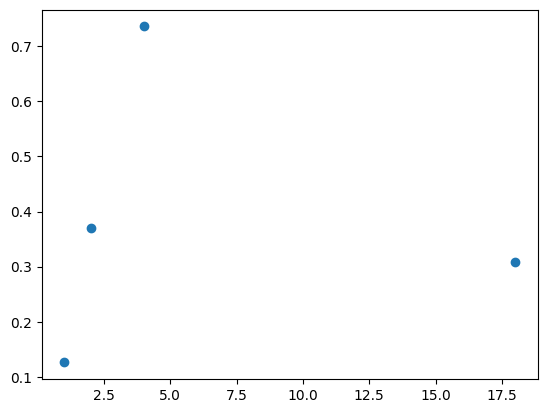

In [31]:
v = torch.rand_like(t)
plt.scatter(t, v);

In [32]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-0.07)

It can be seen that where there is poor correlation between to tensors then the covariance is low.

It is usually conventient to calculate covariance using the following slightly re-worked formula

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [33]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-0.07)

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [34]:
cov / (t.std() * v.std())

tensor(-0.03)

The Pearson coefficient is simply the covariance scaled by the product of the standard deviations

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [35]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.04), tensor(0.81))

If a vector of size n is multiplied by a matrix then if both have mean of zero and standard deviation of 1 then the resulting mean will have a mean of approximately zero and a square of approximately the size of the input

In [36]:
mean,sqr, = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(-0.004908849224448204, 98.05384357452392)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [37]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(-0.003197811666391044, 0.9695751637552187)

In [38]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(5)
    a = torch.randn(3,5)
    y = a@x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/10000,sqr/10000

(-0.008593478992102973, 4.9694563867835795)

In [39]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(5)
    a = torch.randn(3,5)/tensor([5.]).sqrt()
    y = a@x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/10000,sqr/10000

(0.005869235832354616, 1.0015015558817657)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init
(pronounced `her`)

### Background

In [40]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [41]:
from math import sqrt

Create a simple network with two layers and weights and biases

In [42]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [43]:
def lin(x, w, b): return x @ w + b

In [44]:
l1 = lin(x, w1, b1)
l2 = lin(l1, w2, b2)
l1.mean(),l1.std(), l2.mean(), l2.std()

(tensor(0.00), tensor(0.99), tensor(0.16), tensor(1.06))

This is working as expected, with the division by the sqrt of the inputs of each layer effectively normalizing the result

The effect of an activation such as relu can now be investigated

In [45]:
def relu(x): return(x.clamp_min(0.0))

In [46]:
l1 = relu(lin(x, w1, b1))
l2 = lin(l1, w2, b2)
l1.mean(),l1.std(), l2.mean(), l2.std()

(tensor(0.40), tensor(0.58), tensor(1.05), tensor(0.64))

It can be seen that the activation has changed the mean and standard deviation of the output of the first layer quite considerably.  This is why Galrot initialisation does not work well for models with activations.  The cumulative effect of this can be seen below

In [47]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [48]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[1.09, 1.14, 0.89, 0.00, 0.14],
        [1.29, 1.40, 1.06, 0.00, 0.17],
        [1.35, 1.45, 1.17, 0.00, 0.15],
        [0.80, 0.81, 0.66, 0.00, 0.11],
        [1.94, 1.97, 1.60, 0.00, 0.22]])

### Applying an init function

In [49]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [50]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)

In [51]:
model.apply(init_weights);

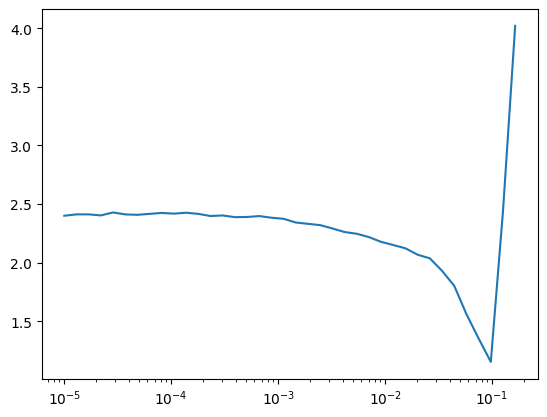

In [52]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [53]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs)

accuracy,loss,epoch,train
0.620,1.158,0,True
0.794,0.562,0,False
0.819,0.489,1,True
0.832,0.460,1,False
0.845,0.423,2,True
0.841,0.432,2,False


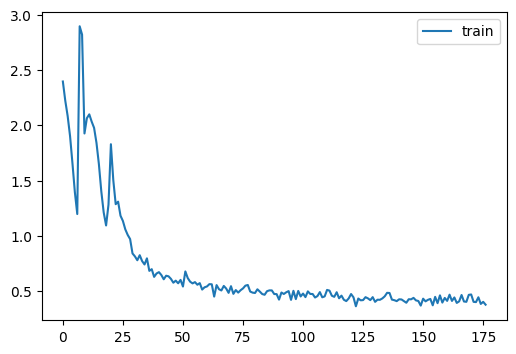

In [54]:
learn.fit(3)

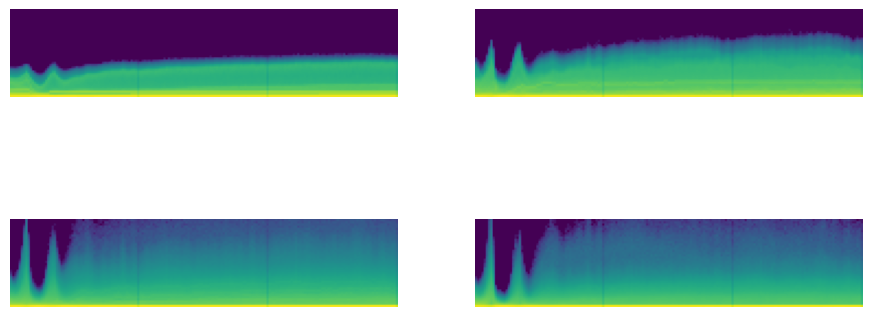

In [55]:
astats.color_dim()

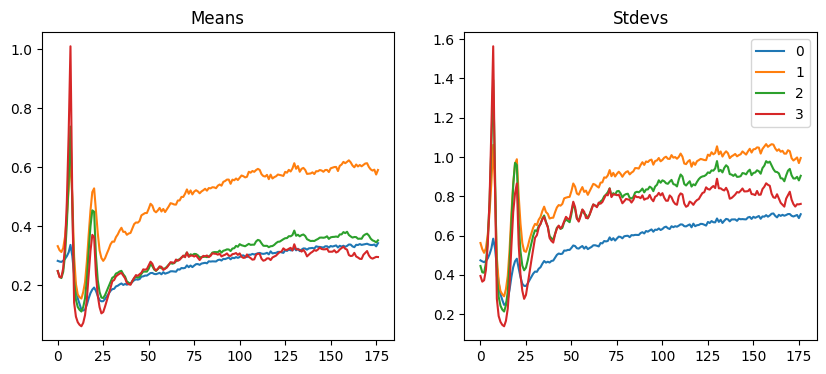

In [56]:
astats.plot_stats()

## Input normalization


To start with check the mean and std deviation of a batch of the input

In [57]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.28), tensor(0.35))

These are clearly well away from the target values.  This can be done and batch level and is just one example of a tranformation, hence a general batch transform class wiil be created and a specific transform setup to carry out the normalisation.

In [58]:
#|export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()
    
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training): 
            learn.batch = self.tfm(learn.batch)

In [59]:
def _norm(x):
    """Function to normalise the input to a neural network from a batch of data.  
    The targets are returned unchanged
    """
    return (x[0]-xmean/xstd, x[1])

In [60]:
# Instantiate the normalisation transform
norm_tfm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.445,1.689,0,True
0.745,0.750,0,False
0.791,0.579,1,True
0.803,0.546,1,False
0.826,0.474,2,True
0.823,0.487,2,False


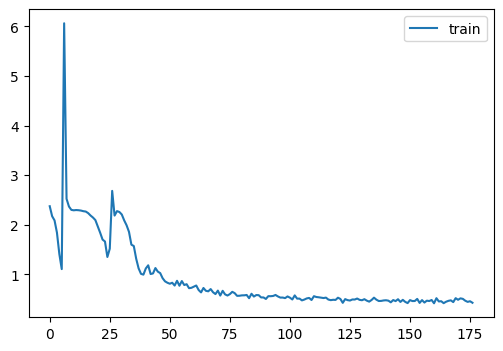

In [61]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm_tfm])
learn.fit(3)

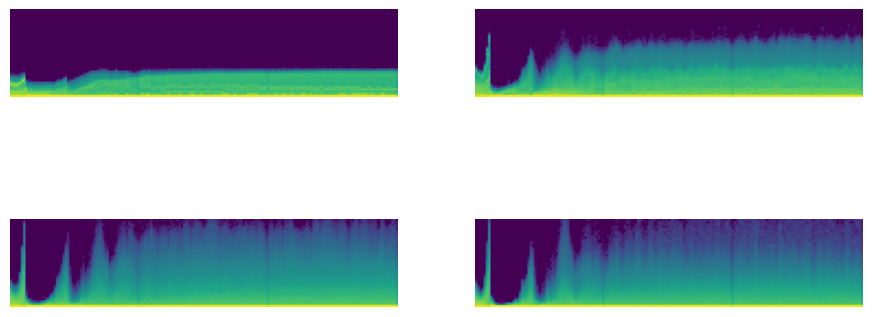

In [62]:
astats.color_dim()

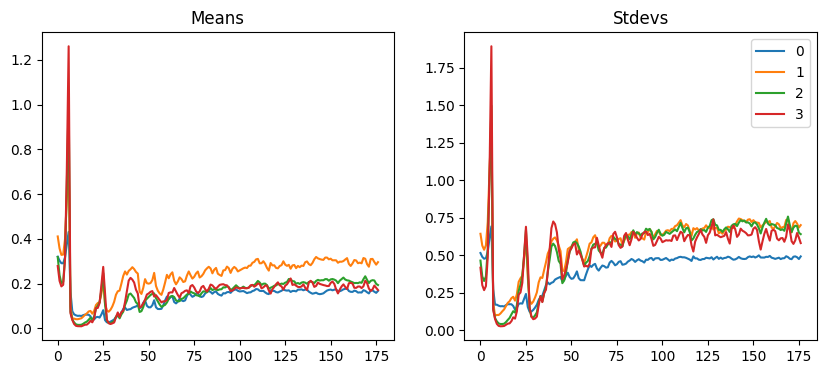

In [63]:
astats.plot_stats()

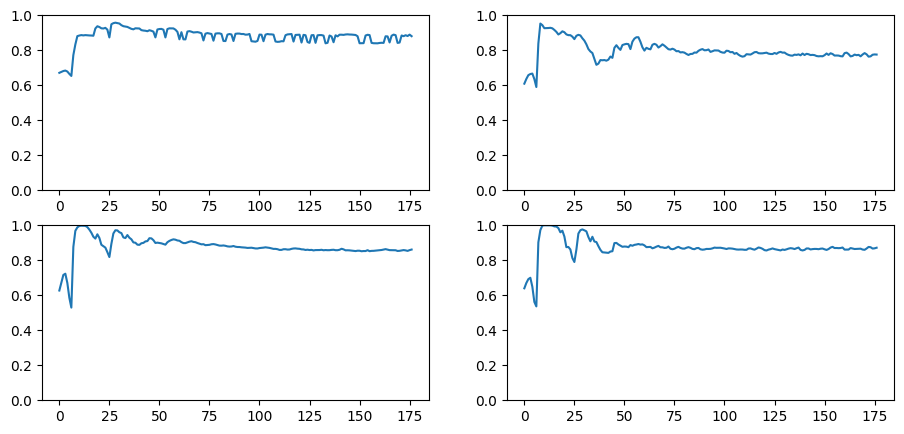

In [64]:
astats.dead_chart()

This has markedly improved the training

Create a transform to both create a tensor from the input and to normalise it. Note that is assumes that xmean and xstd are avilable to the batch and do not need to be calculated.  It also assumes that only the inputs and not the targets are passed in

In [65]:
@inplace
def transformi(b): 
    b[xl] = [(TF.to_tensor(o) - xmean) / xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb, yb = next(iter(dls.train))

In [66]:
xb.mean(), xb.std()

(tensor(    0.00), tensor(1.))

## Alternative activation function General ReLU

In [67]:
#|export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self. maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x = x.clamp_max_(self.maxv)
        return x

In [68]:
#|export
def plot_func(f, start=-5, end=5, steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(visible=True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=1.0)
    plt.axvline(x=0, color='k', linewidth=1.0)

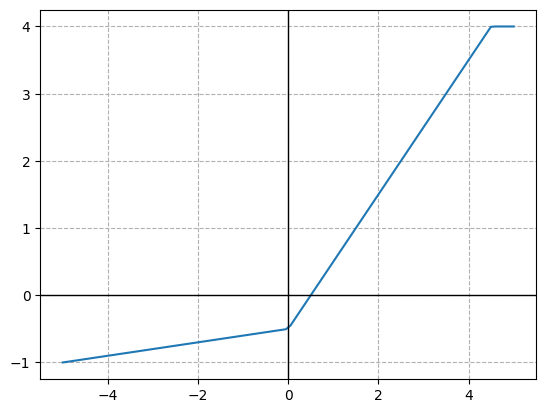

In [69]:
plot_func(GeneralRelu(leak=0.1, sub=0.5, maxv=4.0))

In [70]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [71]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

The pytorch library provides and option to initialise taking into account the effect of leaky relu upon the means and std's when initializing the weights.  leaky should be the slope of the relu in the negative segment

In [72]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [73]:
# Create a partial function for the GeneralRelu activation
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
# Obtain stats for the active relu ouputs
astats = ActivationStatsCB(append_stats, fc.risinstance(GeneralRelu))
cbs = [DeviceCB(),  metrics, ProgressCB(plot=True), astats]
init_w = partial(init_weights, leaky=0.1)

In [74]:
model = get_model(act_gr).apply(init_w)

accuracy,loss,epoch,train
0.766,0.668,0,True
0.844,0.429,0,False
0.864,0.374,1,True
0.860,0.386,1,False
0.879,0.330,2,True
0.872,0.360,2,False


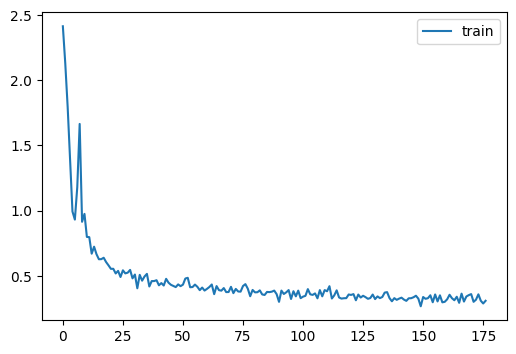

In [75]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

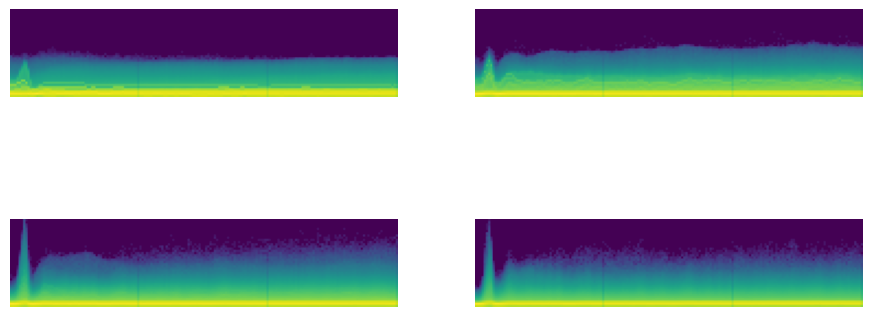

In [76]:
astats.color_dim()

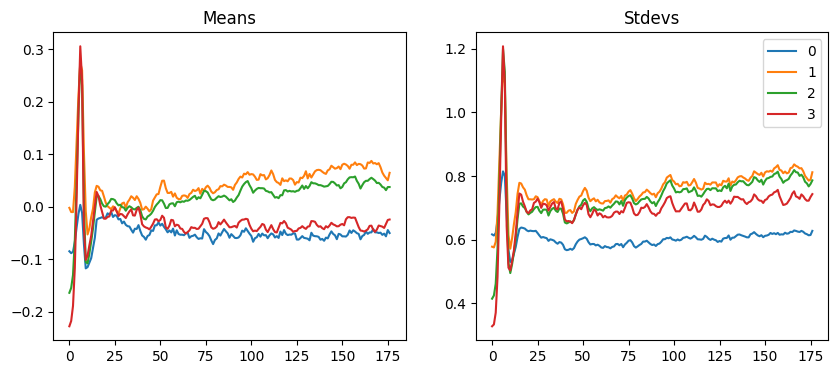

In [77]:
astats.plot_stats()

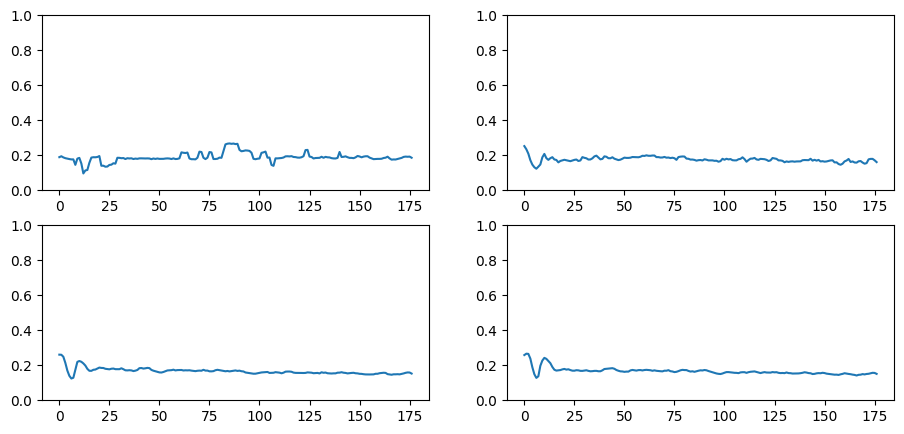

In [78]:
astats.dead_chart()

## LSUV 

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

In [79]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    """Calculate stats for a specific module given the input and output values.  Assigns the mean and std
    as properties of the hook
    """
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()
    
def lsuv_init(m, m_in, xb):
    """ Setput hook for specific module (one of the activation layer outputs usually).  Run a batch of 
    data trhough the model and adjust the weights of the layer feeding the hooked layer to bring the mean
    and std deviation at the end of thta layer to the target values
    
    args:
        m: layer to apply hook to.  Usually the output of an activation
        m_in: layer prior to the activation
        xb: a batch of data
    """
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.mean)>1e-3 or (abs(h.std-1)>1.e-3)):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()
    

To use the model the layers need to be fed in as pairs

In [80]:
model = get_model(act=act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [81]:
for ms in zip(relus, convs):
    print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


Now use the above approach to initialise the model

In [82]:
for ms in zip(relus, convs):
    lsuv_init(*ms, xb.to(def_device))

accuracy,loss,epoch,train
0.777,0.635,0,True
0.847,0.436,0,False
0.862,0.375,1,True
0.855,0.404,1,False
0.875,0.336,2,True
0.860,0.391,2,False


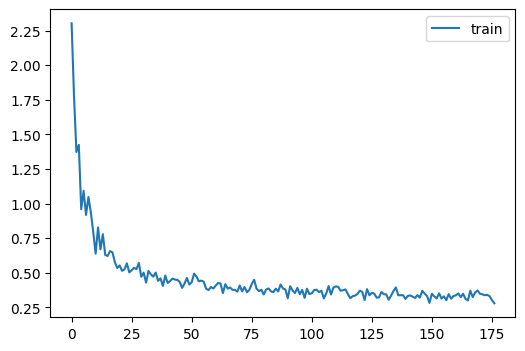

In [83]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

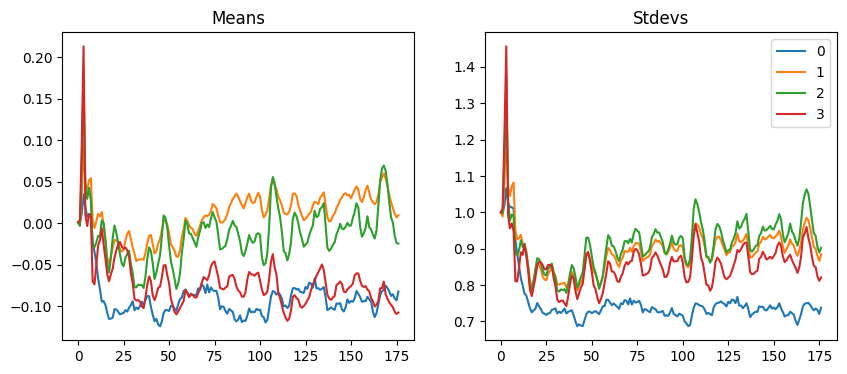

In [84]:
astats.plot_stats()

## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm 

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

Note that LayerNorm will average every pixel for a specific batch item.  Hence every item is independent

In [85]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1.E-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean(dim=(1,2,3), keepdim=True)
        v = x.var(dim=(1,2,3), keepdim=True) 
        x = (x-m) / (v + self.eps).sqrt()
        return x*self.mult + self.add

Create a new version of conv, this time adding in a norm function and control as to whether bias is included.  If batchnorm is being used then there is no point in using bias since batchnorm makes it redundant

In [86]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None:
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [87]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs==None: nfs=[1, 8, 16, 32, 64]
    layers = [conv(nfs[o], nfs[o+1], act=act, norm=norm) for o in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, ks=3, norm=False, act=None, bias=True),
                        nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.772,0.645,0,True
0.848,0.425,0,False
0.864,0.371,1,True
0.863,0.378,1,False
0.881,0.328,2,True
0.872,0.350,2,False


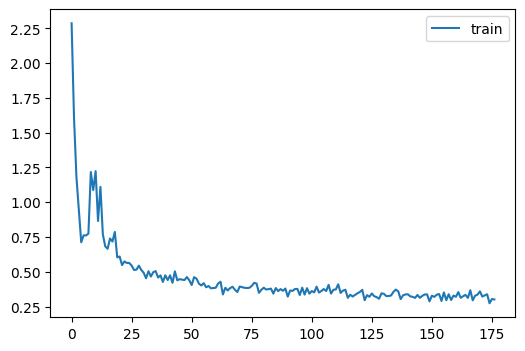

In [88]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(init_w)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [89]:
xb.shape

torch.Size([1024, 1, 28, 28])

In [90]:
tmp = xb.mean((1,2,3), keepdim=True)
tmp.shape

torch.Size([1024, 1, 1, 1])

In [91]:
tmp[0, 0, 0, 0], tmp[1, 0, 0, 0], tmp[2, 0, 0, 0]

(tensor(0.28), tensor(0.40), tensor(-0.40))

### BatchNorm

In [92]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1.E-5):
        """  BatchNorm averages across channels for the whole batch.  It also makes use of 
        momentum so that the means and variances are only changed slowly and do not fluctuate 
        too wildly per batch. After normalizing the input is multiplied by the self.mults and 
        has self.adds added.  These have been defined as parameters and so are afjusted by 
        pytorch as part of the back propagation
        
        args:
            nf: Number of channels or filters
            mom: batch norm momentum
            eps: Amount to add to variance denominator to prevent divide by zero
        """
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('means', torch.ones(1, nf, 1, 1))
        self.register_buffer('vars', torch.zeros(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        # Normalize the input
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds
        

In [93]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']="1"

In [94]:
model = get_model(act_gr, norm=BatchNorm).apply(init_w)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)

accuracy,loss,epoch,train
0.788,0.581,0,True
0.825,0.499,0,False
0.871,0.351,1,True
0.859,0.384,1,False
0.886,0.311,2,True
0.874,0.345,2,False


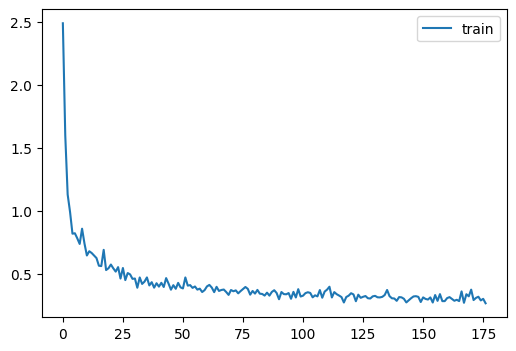

In [95]:
learn.fit(3)

accuracy,loss,epoch,train
0.791,0.565,0,True
0.850,0.418,0,False
0.872,0.347,1,True
0.865,0.371,1,False
0.887,0.306,2,True
0.862,0.371,2,False


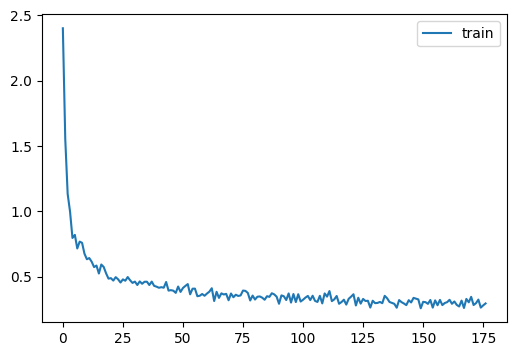

In [96]:
model = get_model(act_gr, norm=BatchNorm).apply(init_w)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](images/norms.png)

## Towards 90% 

In [ ]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.793,0.568,0,True
0.850,0.417,0,False
0.869,0.363,1,True
0.861,0.379,1,False
0.884,0.320,2,True
0.870,0.353,2,False


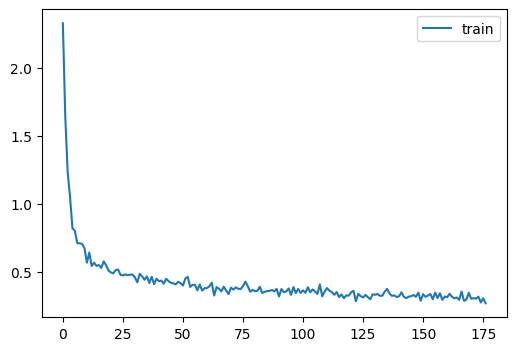

In [102]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(init_w)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.899,0.282,0,True
0.881,0.329,0,False
0.902,0.273,1,True
0.883,0.325,1,False


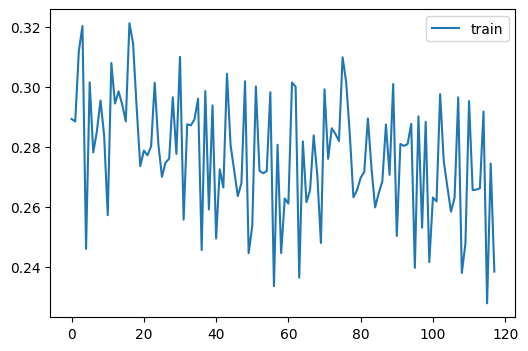

In [103]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export 

In [104]:
import nbdev; nbdev.nbdev_export()